In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

tf.test.gpu_device_name()




'/device:GPU:0'

In [2]:
from tensorflow import keras

from keras import distribute

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # без этого не работает
#tf.sysconfig.get_compile_flags()

In [3]:
import pathlib
dataset_url   ="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir   =   tf.keras.utils.get_file('flower_photos',origin=dataset_url, untar=True)


In [4]:
print(data_dir)

C:\Users\drug1\.keras\datasets\flower_photos


In [5]:
data_dir = pathlib.Path(data_dir)
#image_count = len(list(data_dir.glob('*/*.jpg')))
#print(image_count)

In [6]:
#roses = list(data_dir.glob('roses/*'))
#PIL.Image.open(str(roses[0]))


In [7]:
batch_size = 32 # размер порции данных
img_height = 170 # размер картинок
img_width = 170


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
print(train_ds)
print(val_ds)

<BatchDataset shapes: ((None, 170, 170, 3), (None,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 170, 170, 3), (None,)), types: (tf.float32, tf.int32)>


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


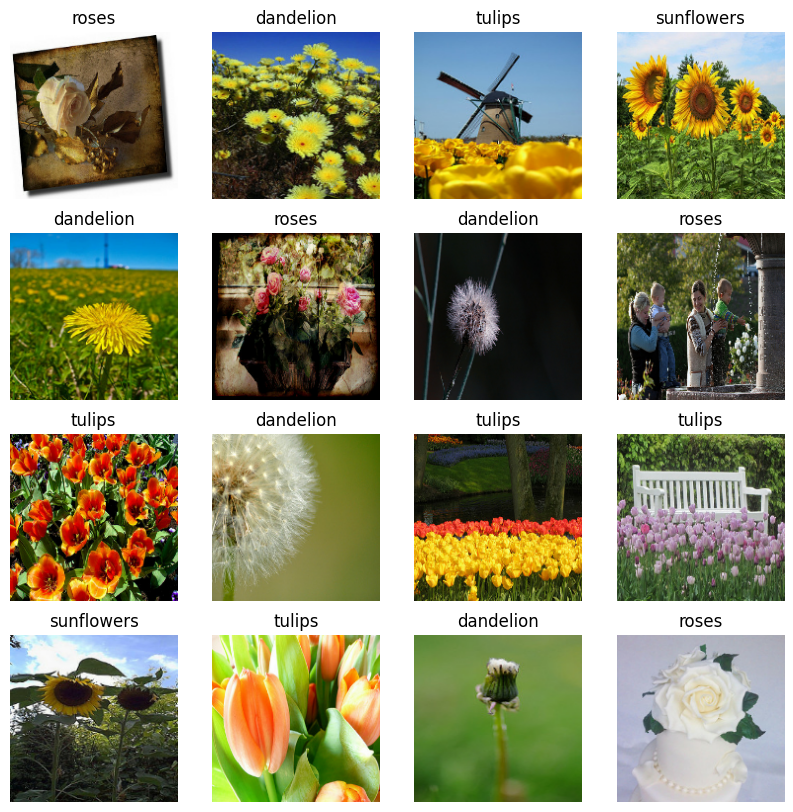

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()


In [12]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 170, 170, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# СТАНДАРТИЗАЦИЯ
normalization_layer = layers.Rescaling(1./255)

'''
normalized_ds = train_ds.map(lambda   x,   y:
(normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
'''


'\nnormalized_ds = train_ds.map(lambda   x,   y:\n(normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\nfirst_image = image_batch[0]\n# Notice the pixel values are now in `[0,1]`.\nprint(np.min(first_image), np.max(first_image))\n'

In [15]:
# МОДЕЛЬ

num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255,   input_shape=(img_height,   img_width,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
# Используем оптимизатор АДАМ (улучшитель градиентного спуска)
# Функция потерь
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 170, 170, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 170, 170, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0

In [18]:
# обучение модели

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
92/92 [==============================] - 11s 22ms/step - loss: 1.5085 - accuracy: 0.3331 - val_loss: 1.1468 - val_accuracy: 0.5245
Epoch 2/10
92/92 [==============================] - 1s 14ms/step - loss: 1.0687 - accuracy: 0.5773 - val_loss: 1.0001 - val_accuracy: 0.6185
Epoch 3/10
92/92 [==============================] - 1s 14ms/step - loss: 0.9304 - accuracy: 0.6339 - val_loss: 0.9800 - val_accuracy: 0.6172
Epoch 4/10
92/92 [==============================] - 1s 14ms/step - loss: 0.7712 - accuracy: 0.7108 - val_loss: 0.9308 - val_accuracy: 0.6471
Epoch 5/10
92/92 [==============================] - 1s 14ms/step - loss: 0.6185 - accuracy: 0.7769 - val_loss: 0.9398 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 1s 14ms/step - loss: 0.5009 - accuracy: 0.8082 - val_loss: 1.0274 - val_accuracy: 0.6308
Epoch 7/10
92/92 [==============================] - 1s 15ms/step - loss: 0.3533 - accuracy: 0.8791 - val_loss: 1.0397 - val_accuracy: 0.6322
Epoch 8/10
9

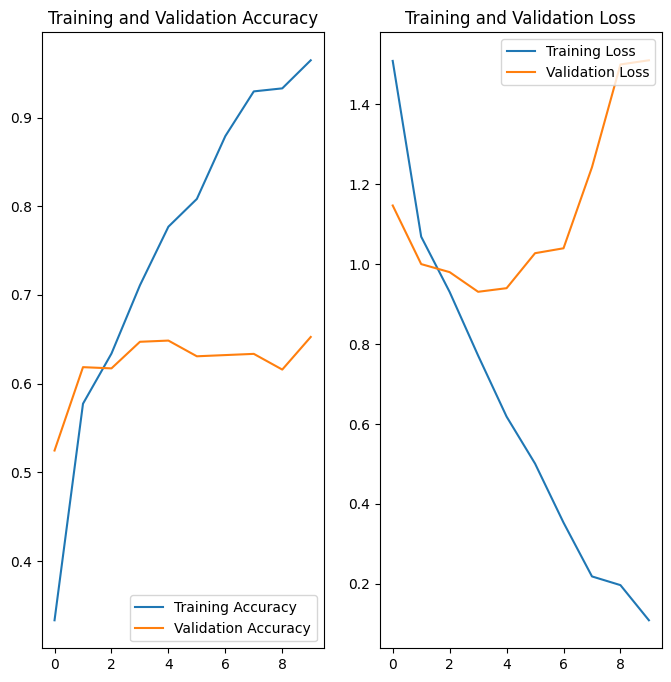

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
# Расширение данных

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


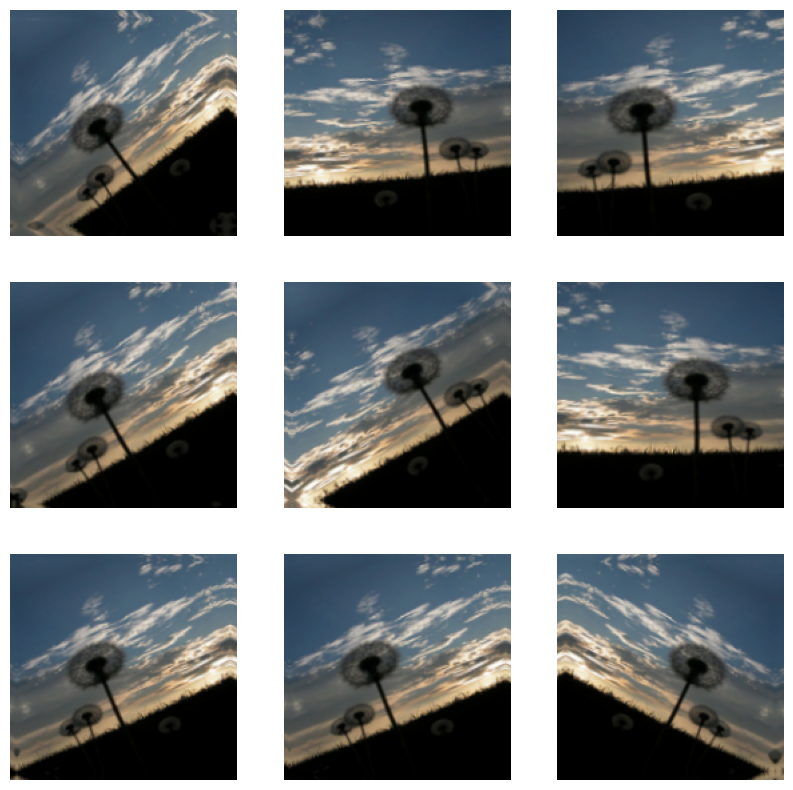

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
# ОТСЕВ
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy
(from_logits=True), metrics=['accuracy'])


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 170, 170, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 170, 170, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 170, 170, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 85, 85, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 64)       

In [25]:

# ОБУЧЕНИЕ
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

  

Epoch 1/15
92/92 [==============================] - 2s 19ms/step - loss: 1.2603 - accuracy: 0.4646 - val_loss: 1.0424 - val_accuracy: 0.6022
Epoch 2/15
92/92 [==============================] - 2s 18ms/step - loss: 1.0259 - accuracy: 0.5954 - val_loss: 1.0185 - val_accuracy: 0.5858
Epoch 3/15
92/92 [==============================] - 2s 18ms/step - loss: 0.9222 - accuracy: 0.6281 - val_loss: 0.8915 - val_accuracy: 0.6553
Epoch 4/15
92/92 [==============================] - 2s 18ms/step - loss: 0.8598 - accuracy: 0.6723 - val_loss: 0.9460 - val_accuracy: 0.6540
Epoch 5/15
92/92 [==============================] - 2s 18ms/step - loss: 0.7946 - accuracy: 0.6897 - val_loss: 0.8495 - val_accuracy: 0.6798
Epoch 6/15
92/92 [==============================] - 2s 18ms/step - loss: 0.7423 - accuracy: 0.7115 - val_loss: 0.8235 - val_accuracy: 0.7030
Epoch 7/15
92/92 [==============================] - 2s 18ms/step - loss: 0.7025 - accuracy: 0.7279 - val_loss: 0.7364 - val_accuracy: 0.7139
Epoch 8/15
92

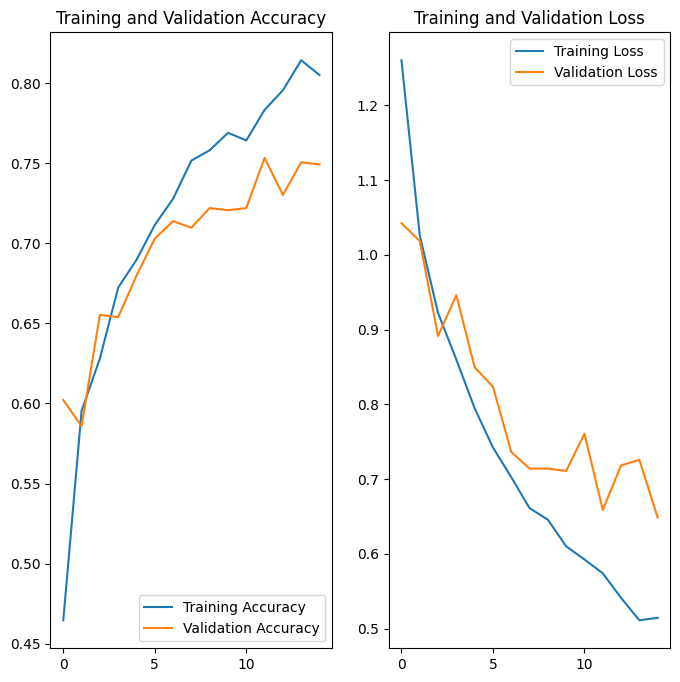

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
from IPython.display import Image, display


sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path   =   tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)






#Image(filename=sunflower_path) 




img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to sunflowers with a 98.74 percent confidence.


In [28]:
str_path = "C:\\Users\\drug1\\.keras\\datasets\\"

print(sunflower_path)
print(str_path + "1.jpg")

C:\Users\drug1\.keras\datasets\Red_sunflower
C:\Users\drug1\.keras\datasets\1.jpg


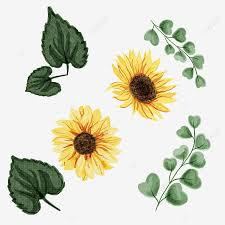

This image most likely belongs to roses with a 56.94 percent confidence.


In [29]:
# Проверяем на  произвольных изображениях цветов  с интернета


path = pathlib.Path(str_path + "1.jpg")
display(Image(filename=path))

img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)


# Рисунок подсолнуха распознала плохо

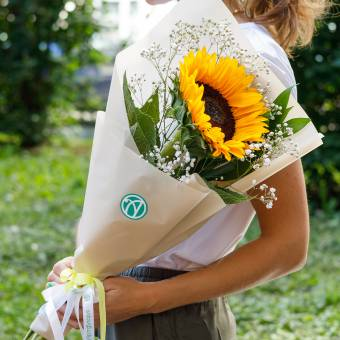

This image most likely belongs to sunflowers with a 62.60 percent confidence.


In [30]:
path = pathlib.Path(str_path + "2.jpg")
display(Image(filename=path))


img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)

# 

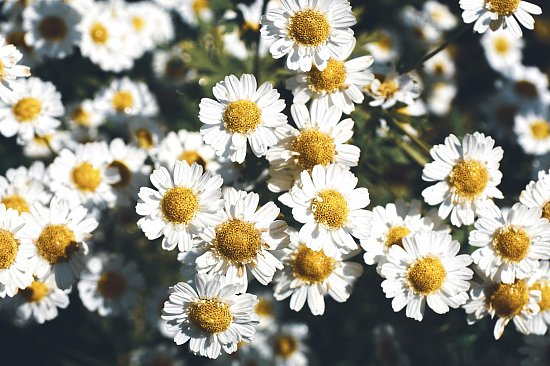

This image most likely belongs to daisy with a 96.02 percent confidence.


In [31]:
path = pathlib.Path(str_path + "3.jpg")
display(Image(filename=path))


img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)



# Ромашки опознала 

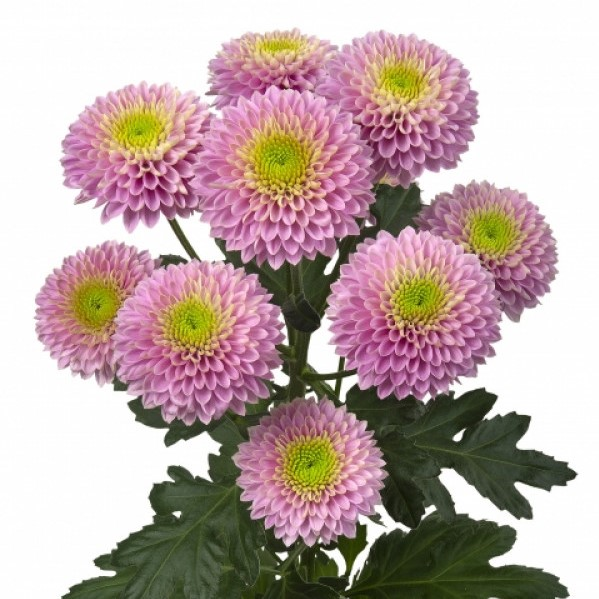

This image most likely belongs to roses with a 73.55 percent confidence.


In [33]:
path = pathlib.Path(str_path + "4.jpg")
display(Image(filename=path))


img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)


# Хризантиемы путает с розами (в обучающем наборе хризантем не было)
